<a href="https://colab.research.google.com/github/kinzinzz/Analysis_of_Fine_Dust/blob/master/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [3]:
df = pd.read_csv('./drive/MyDrive/2022.11.02.CSV', encoding='cp949')

In [4]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [5]:
df.set_index("timeStamp", inplace=True)

In [6]:
seq_length = 60
batch = 8
# train:val:test = 8:1:1

train_size = int(len(df)*0.8)

train_set = df[0:train_size]
val_set = df[train_size:train_size + int(len(df)*0.1)]
test_set = df[train_size + int(len(df)*0.1):]

In [7]:
# 데이터 스케일링
# input scale
scaler_x = MinMaxScaler()

scaler_x.fit(train_set.iloc[:,:-1])
train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
val_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:,:-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:,:-1])

# output scale
scaler_y = MinMaxScaler()

scaler_y.fit(train_set.iloc[:, [-1]])
train_set.iloc[:, -1] = scaler_y.transform(train_set.iloc[:, [-1]])
val_set.iloc[:, -1] = scaler_y.transform(val_set.iloc[:, [-1]])
test_set.iloc[:, -1] = scaler_y.transform(test_set.iloc[:, [-1]])

<ipython-input-7-5e3338e29735>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
<ipython-input-7-5e3338e29735>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:,:-1])
<ipython-input-7-5e3338e29735>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [8]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def build_dataset(time_series, seq_length):
    data_x = []
    data_y = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]

        data_x.append(_x)
        data_y.append(_y)

    return np.array(data_x), np.array(data_y)

trainX , trainY = build_dataset(np.array(train_set), seq_length)
valX, valY = build_dataset(np.array(val_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

In [9]:
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

valX_tensor = torch.FloatTensor(valX)
valY_tensor = torch.FloatTensor(valY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
val_dataset = TensorDataset(valX_tensor, valY_tensor)
test_dataset = TensorDataset(testX_tensor, testY_tensor)

train_dataloader = DataLoader(train_dataset, 
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True)

val_dataloader = DataLoader(val_dataset, 
                        batch_size = batch,
                        shuffle=True,
                        drop_last=True) 

In [10]:
# 모델링
class FineDustPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_length, n_layers):
        super(FineDustPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_length = seq_length
        self.n_layers = n_layers
        self.n_features = n_features
        self.c1 = nn.Conv1d(
            in_channels = 12,
            out_channels = 16,
            kernel_size = 3,
            stride = 1            
        )
        self.c2 = nn.Conv1d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = 2,
            stride = 1,
            dilation = 2
        )
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=50,
            num_layers=1,
            bias=True,
            batch_first=True
            # dropout=0.3,            
        )
        self.fc = nn.Linear(in_features=50, out_features=1, bias = True)
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_length, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_length, self.n_hidden)
        )
    
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.c1(x)
        x = self.c2(x)
        
        x = x.transpose(1,2)
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        x = hidden[-1]
        
        y_pred = self.fc(x)
        return y_pred

In [11]:
def train_model(model, train_df, val_df, learning_rate=None, num_epochs=100, verbose = 10, patience = 10):
    criterion = torch.nn.L1Loss() #loss_fn 
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for batch_idx, samples in enumerate(train_df):
            
            x_train, y_train = samples
            
            # seq hidden state reset
            model.reset_hidden_state()
            
            y_pred = model(x_train)
            
            # train loss
            loss = criterion(y_pred, y_train) 
            
            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_df))

        if val_df is not None:

            with torch.no_grad():

                val_loss = 0

                for val_batch_idx, val_samples in enumerate(val_df):
                    
                    x_val, y_val = samples
                    model.reset_hidden_state()
                    
                    val_pred = model(x_val)
                    val_step_loss = criterion(val_pred, y_val)
                   
                    val_loss += val_step_loss
                    
            val_hist.append(val_loss / len(val_df))

            
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_df)} val loss: {val_loss / len(val_df)}')

            
            if (t % patience == 0) & (t != 0):
                
                
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_df)}')

            
    return model, train_hist, val_hist

In [12]:
model = FineDustPredictor(
    n_features=3,
    n_hidden=50,
    seq_length=seq_length,
    n_layers=1
)
print(model)

FineDustPredictor(
  (c1): Conv1d(12, 16, kernel_size=(3,), stride=(1,))
  (c2): Conv1d(16, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
  (lstm): LSTM(32, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [13]:
model, train_hist, val_hist = train_model(
    model,
    train_dataloader,
    val_dataloader,
    learning_rate=0.001,    
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08918057434881727 val loss: 0.08544731885194778
Epoch 10 train loss: 0.02991505362248669 val loss: 0.027462376281619072
Epoch 20 train loss: 0.028330743576710424 val loss: 0.013316580094397068
Epoch 30 train loss: 0.027908125543035567 val loss: 0.02021089941263199
Epoch 40 train loss: 0.02764389809841911 val loss: 0.021532835438847542
Epoch 50 train loss: 0.027404413977637886 val loss: 0.02802315168082714
Epoch 60 train loss: 0.026668327922622363 val loss: 0.019325800240039825
Epoch 70 train loss: 0.02625714650688072 val loss: 0.03313307464122772
Epoch 80 train loss: 0.026773869091024003 val loss: 0.015627458691596985
Epoch 90 train loss: 0.02588943186371277 val loss: 0.012771465815603733


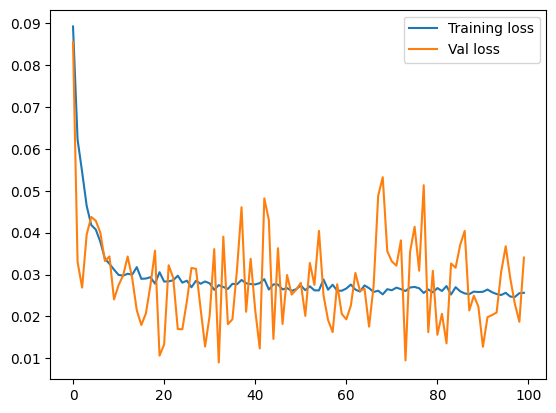

In [14]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

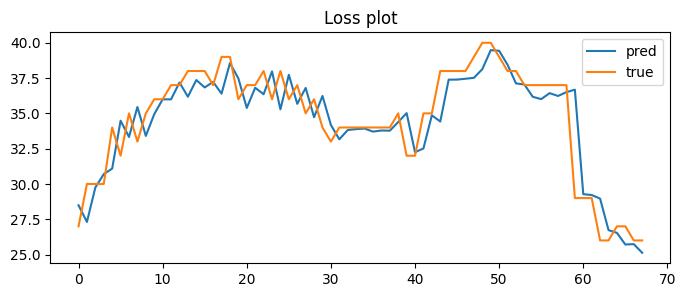

In [15]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)
    
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor)

fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.legend()
plt.show()